In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
import datetime as dt

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [3]:
#ROS TIME IS ALREADY WITH REFERENCE FROM EPOCH HENCE NO NEED TO SUBTRACT FROM 1970
def epoch_setup(df):
    #a=dt.datetime.utcfromtimestamp(0)
    #dtx = []
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    #for i in range (len(df.time)):
    #    dtx.append((dt.datetime.fromtimestamp(df.time[i])-a).total_seconds()) 
    #df.insert(1,'epoch',dtx)
    sync_time = df.time-df.time[0]
    df.insert(1,'sync_time',sync_time)
    return df

### Stationary Wind Bag B

31.988526614621183


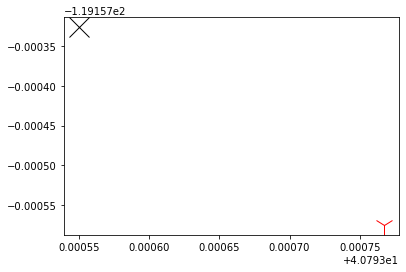

In [4]:
#distance between windstation and odor source
plt.plot([40.79355], [-119.157326], marker='x', markersize=20, color="black")
plt.plot([40.79376709443614], [-119.15757512132207], marker='1', markersize=20, color="red")

#5 inches; 0.127 meters; 12.7 cm

from geopy import distance
coords_1 = (40.79355, -119.157326)
coords_2 = (40.79376709443614, -119.15757512132207)

print (distance.geodesic(coords_1, coords_2).meters)

In [5]:
#ubuntu
#fname='~/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
#mac 
fname = '~/Documents/Myfiles/DataAnalysis/data/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
wind_df.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V', 'W', 'T', 'H', 'AD', 'MD'],
      dtype='object')

In [6]:
sync_time_x = wind_df.time_epoch-wind_df.time_epoch[0]
wind_df.insert(1,'sync_time',sync_time_x)

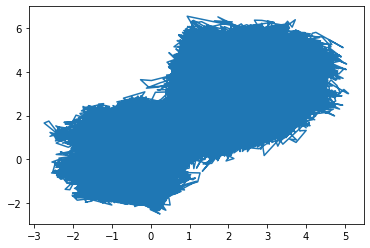

In [89]:
plt.plot(wind_df.sync_time, wind_df.S2)

### Extract Wind Data for Bag 02 duration

In [8]:
df2 =pd.DataFrame
df2 = wind_df.loc[(wind_df.time_epoch >= 1603221192.55) & (wind_df.time_epoch <= 1603221492.29)]


In [9]:
df2.index= df2.index-df2.index[0]
sync_time0 = df2.time_epoch-df2.time_epoch[0]
df2.insert(1,'sync_time',sync_time0)

ValueError: cannot insert sync_time, already exists

Text(0.5, 0, 'Time (seconds)')

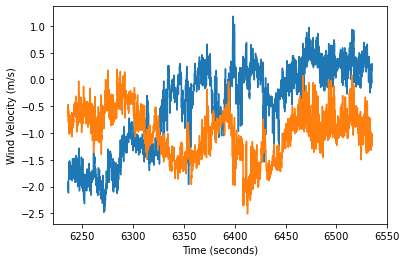

In [10]:
ff = plt.figure()
ax= ff.add_subplot(111)
ax.plot(df2.sync_time,df2.U)
ax.plot(df2.sync_time,df2.V)
ax.set_ylabel("Wind Velocity (m/s)")
ax.set_xlabel("Time (seconds)")
#plt.savefig('../figure/windspeed.jpg')

In [11]:
# integrating velocity in eastwest and northsouth to get the position for every particle at time t
posu=[]
posv=[]
for i in range(len(df2.time_epoch)):
    posu.append(integrate.cumtrapz(df2.U[i:],df2.time_epoch[i:], axis=0, initial = 0.0)) 
    posv.append(integrate.cumtrapz(df2.V[i:],df2.time_epoch[i:], axis=0, initial = 0.0))


In [12]:
# integrating TOGETHER velocity in eastwest and northsouth to get the position for every particle at time t 
positions= []
for i in range(len(df2.time_epoch)):
    positions.append(integrate.cumtrapz([df2.U[i:],df2.V[i:]], df2.time_epoch[i:], axis=1, initial =0.0))

In [13]:
positions[0] #both array 1 = X; array 2 =Y

array([[ 0.00000000e+00, -2.05005670e-01, -4.07011256e-01, ...,
        -1.45117296e+02, -1.45094796e+02, -1.45071795e+02],
       [ 0.00000000e+00, -5.45015073e-02, -1.04002876e-01, ...,
        -2.94884989e+02, -2.94998492e+02, -2.95113996e+02]])

In [14]:
#x =list(zip(posu,posv))

In [72]:
#creating dataframes for each westeast particle and northsouth
westeast=pd.DataFrame(posu,columns=['particle{}'.format(x+1) for x in range(len(posu))]) #particle U
northsouth=pd.DataFrame(posv,columns=['particle{}'.format(x+1) for x in range(len(posv))]) #particle in V

In [73]:
#converting rows to columns for Position westeast
dfi = pd.DataFrame()
dfi['index']=westeast.index
westeast=westeast.T
westeast.set_index(dfi.index, inplace=True)
westeast.columns = ['particle' + str(col) for col in westeast.columns]

#adding in time from main dataframe
#westeast.insert(0, 'epoch_time', df2.time_epoch)
#westeast.insert(1, 'sync_time',df2.sync_time)

In [77]:
westeast.iloc[:,0]

0         0.000000
1        -0.205006
2        -0.407011
3        -0.607017
4        -0.802022
           ...    
2992   -145.148797
2993   -145.138297
2994   -145.117296
2995   -145.094796
2996   -145.071795
Name: particle0, Length: 2997, dtype: float64

In [78]:
delta=pd.DataFrame()
delta[0] = westeast.iloc[:,0]

In [66]:
i =2
westeast['particle'+str(i)].shift(periods=2)


0              NaN
1              NaN
2         0.000000
3        -0.200006
4        -0.395010
           ...    
2992   -144.741786
2993   -144.731286
2994   -144.710285
2995   -144.687784
2996   -144.664784
Name: particle2, Length: 2997, dtype: float64

In [80]:
for i in range(1,len(westeast.columns)):
    delta[i]=westeast['particle' + str(i)].shift(periods=i)


In [82]:
delta.columns = ['particle' + str(col) for col in delta.columns]
delta.fillna(0)

,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,particle8,particle9,...,particle2987,particle2988,particle2989,particle2990,particle2991,particle2992,particle2993,particle2994,particle2995,particle2996
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,-0.205006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.407011,-0.202006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-0.607017,-0.402011,-0.200006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,-0.802022,-0.597016,-0.395010,-0.195005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,-145.148797,-144.943791,-144.741786,-144.541780,-144.346775,-144.153770,-143.950264,-143.751759,-143.566754,-143.384249,...,0.009000,0.001500,-0.002500,-0.003500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2993,-145.138297,-144.933291,-144.731286,-144.531280,-144.336275,-144.143270,-143.939764,-143.741259,-143.556253,-143.373748,...,0.019501,0.012000,0.008000,0.007000,0.010500,0.010500,0.000000,0.000000,0.000000,0.0
2994,-145.117296,-144.912291,-144.710285,-144.510279,-144.315274,-144.122269,-143.918764,-143.720258,-143.535253,-143.352748,...,0.040501,0.033001,0.029001,0.028001,0.031501,0.031501,0.021001,0.000000,0.000000,0.0
2995,-145.094796,-144.889790,-144.687784,-144.487779,-144.292774,-144.099769,-143.896263,-143.697757,-143.512752,-143.330247,...,0.063002,0.055502,0.051501,0.050501,0.054001,0.054001,0.043501,0.022501,0.000000,0.0


In [83]:
#converting rows to columns for position northsouth
dfi['index1']=northsouth.index
northsouth=northsouth.T
northsouth.set_index(dfi.index1, inplace=True)
northsouth.columns = ['particle' + str(col) for col in northsouth.columns]

#adding in time from main dataframe
# northsouth.insert(0, 'epoch_time', df2.time_epoch)
# northsouth.insert(1, 'sync_time',df2.sync_time)
# northsouth

In [84]:
gamma=pd.DataFrame()
gamma[0] = northsouth.iloc[:,0]
for i in range(1,len(westeast.columns)):
    gamma[i]=northsouth['particle' + str(i)].shift(periods=i)
    
gamma.columns = ['particle' + str(col) for col in gamma.columns]
gamma.fillna(0)

,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,particle8,particle9,...,particle2987,particle2988,particle2989,particle2990,particle2991,particle2992,particle2993,particle2994,particle2995,particle2996
index1,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,-0.054502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.104003,-0.049501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-0.161004,-0.106503,-0.057002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,-0.227506,-0.173005,-0.123503,-0.066502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,-294.654983,-294.600482,-294.550980,-294.493979,-294.427477,-294.359475,-294.284473,-294.211971,-294.150969,-294.088968,...,-0.541515,-0.435512,-0.328009,-0.216506,-0.105503,0.000000,0.000000,0.000000,0.000000,0.0
2993,-294.767486,-294.712984,-294.663483,-294.606482,-294.539980,-294.471978,-294.396976,-294.324474,-294.263472,-294.201470,...,-0.654018,-0.548015,-0.440512,-0.329009,-0.218006,-0.112503,0.000000,0.000000,0.000000,0.0
2994,-294.884989,-294.830488,-294.780986,-294.723985,-294.657483,-294.589481,-294.514479,-294.441977,-294.380975,-294.318974,...,-0.771521,-0.665518,-0.558015,-0.446512,-0.335509,-0.230006,-0.117503,0.000000,0.000000,0.0


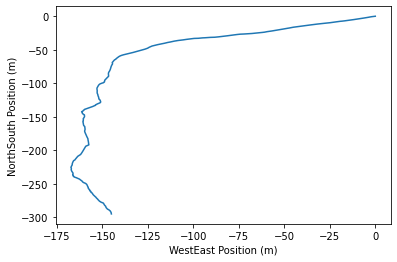

In [64]:
plt.plot(westeast.particle0,northsouth.particle0)
plt.xlabel('WestEast Position (m)')
plt.ylabel('NorthSouth Position (m)')
plt.savefig('../figure/WindIntegratedPosition.jpg')

### Loading Bag File from the Sensor Stack with almost the same datetime

In [18]:
df= pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Interpolated_0.h5')
time= df.master_time-df.master_time[0]
df.insert(1,'sync_time',time) 
df

,master_time,sync_time,odor,trisonica_U,trisonica_V,lat,lon
0,1.603221e+09,0.000000,0.634854,0.280000,1.160000,40.793749,-119.157556
1,1.603221e+09,0.004997,0.635494,0.289993,1.160000,40.793749,-119.157556
2,1.603221e+09,0.009995,0.635827,0.299985,1.160000,40.793749,-119.157556
3,1.603221e+09,0.014992,0.635718,0.309978,1.160000,40.793749,-119.157556
4,1.603221e+09,0.019989,0.635305,0.319970,1.160000,40.793749,-119.157556
...,...,...,...,...,...,...,...
59757,1.603221e+09,298.620872,0.591438,1.333149,-1.755375,40.793697,-119.157631
59758,1.603221e+09,298.625870,0.589259,1.496149,-1.733239,40.793697,-119.157631
59759,1.603221e+09,298.630867,0.589552,1.331477,-1.796238,40.793697,-119.157631
59760,1.603221e+09,298.635864,0.590273,1.110641,-1.873829,40.793697,-119.157631


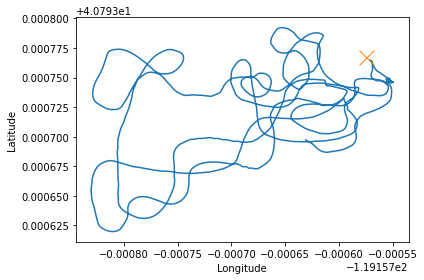

In [19]:
plt.plot(df.lon, df.lat)
plt.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('../figure/gpstrajectory.jpg')

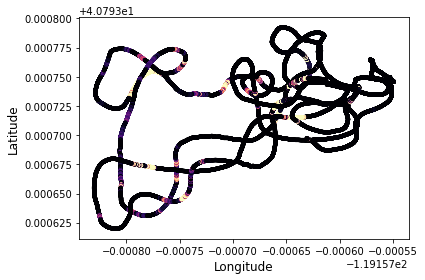

In [27]:
f= plt.figure()
ax1 = f.add_subplot(111)
ax1.scatter(df.lon, df.lat, c=df.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
f.tight_layout()
f.savefig('../figure/odordata.jpg')

(100.0, 300.0)

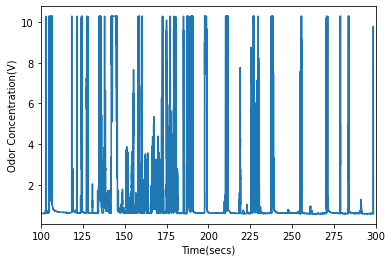

In [114]:
plt.plot(df.sync_time,df.odor)
plt.xlabel('Time(secs)')
plt.ylabel('Odor Concentration(V)')
plt.xlim(100,300)

#plt.savefig('../figure/odorconcentrationvstime.jpg')

In [98]:
query = 'odor >= 5'
df_t=df.query(query)


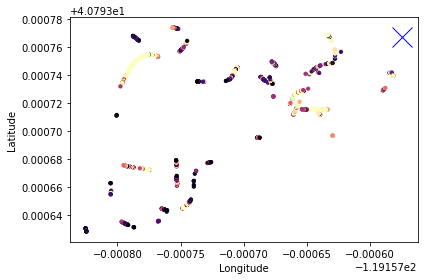

In [99]:
plt.scatter(df_t.lon, df_t.lat, c=df_t.odor, s=10, cmap='magma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="b")
plt.tight_layout()
plt.savefig('../figure/odorconcentrationlocation.jpg')

In [25]:
# font = {'family' : 'normal',
#         'size'   : 16}

# plt.rc('font', **font)

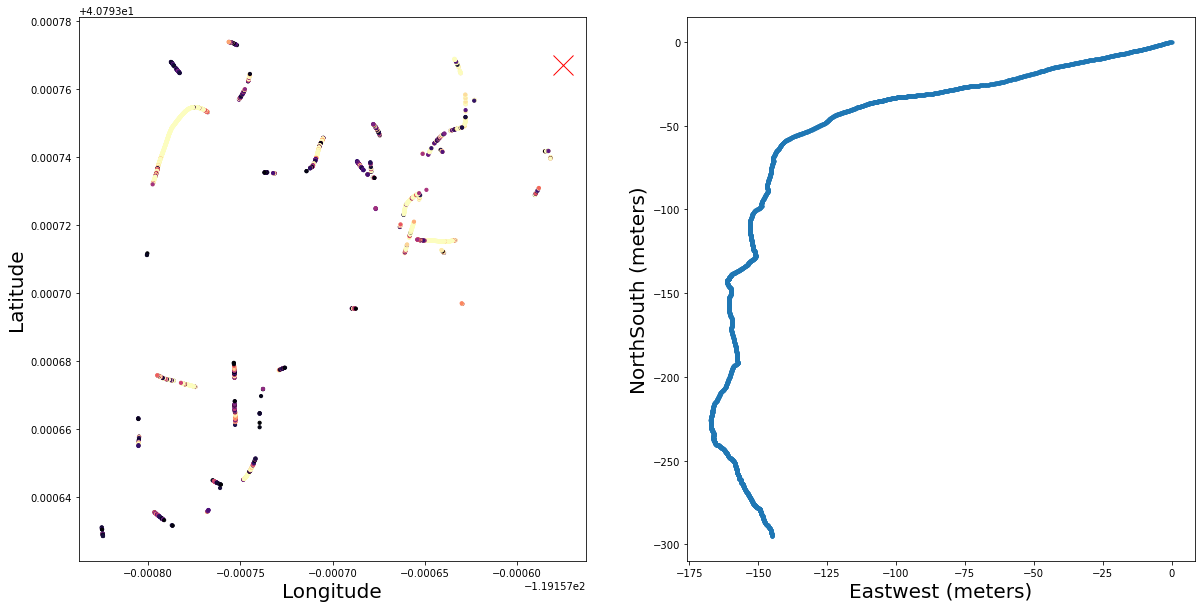

In [100]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(df_t.lon, df_t.lat, c=df_t.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(westeast.particle0,northsouth.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
f.savefig('../figure/position_odor_comp.jpg')



### Zooming into odor and position

In [104]:
query = 'sync_time >= 150.0 and sync_time <=180.0'

In [105]:
dfodor1=df.query(query)

In [106]:
dfwe1=westeast.query(query)
dfns1=northsouth.query(query)

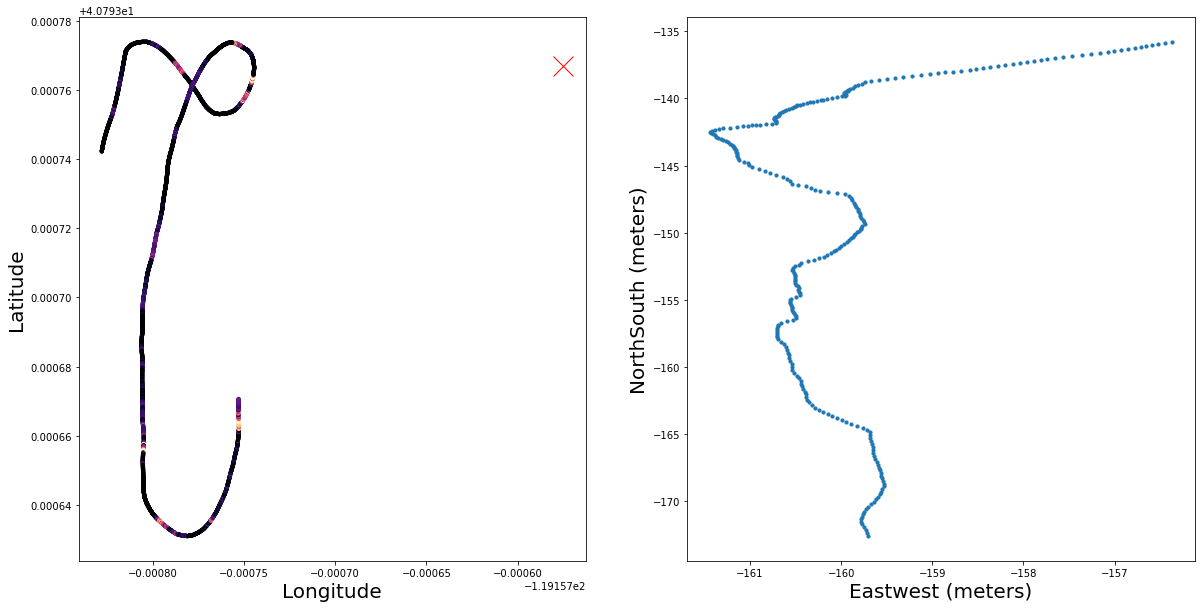

In [119]:
f0, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(dfodor1.lon, dfodor1.lat, c=dfodor1.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(dfwe1.particle0,dfns1.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
#f0.savefig('../figure/position_odor_zoom1.jpg')

In [112]:
query1 = 'sync_time >= 175.0 and sync_time <=225.0'
dfodor2=df.query(query1)
dfwe2=westeast.query(query1)
dfns2=northsouth.query(query1)

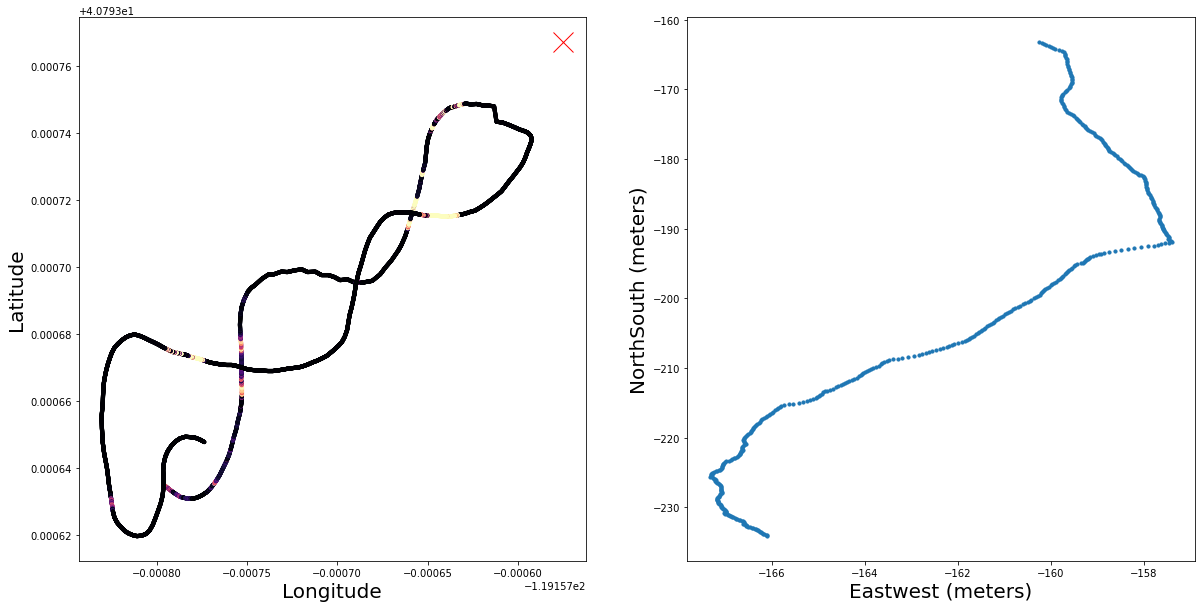

In [120]:
f1, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(dfodor2.lon, dfodor2.lat, c=dfodor2.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(dfwe2.particle0,dfns2.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
#f1.savefig('../figure/position_odor_zoom2.jpg')

In [115]:
query2 = 'sync_time >= 100.0 and sync_time <=150.0'
dfodor3=df.query(query2)
dfwe3=westeast.query(query2)
dfns3=northsouth.query(query2)

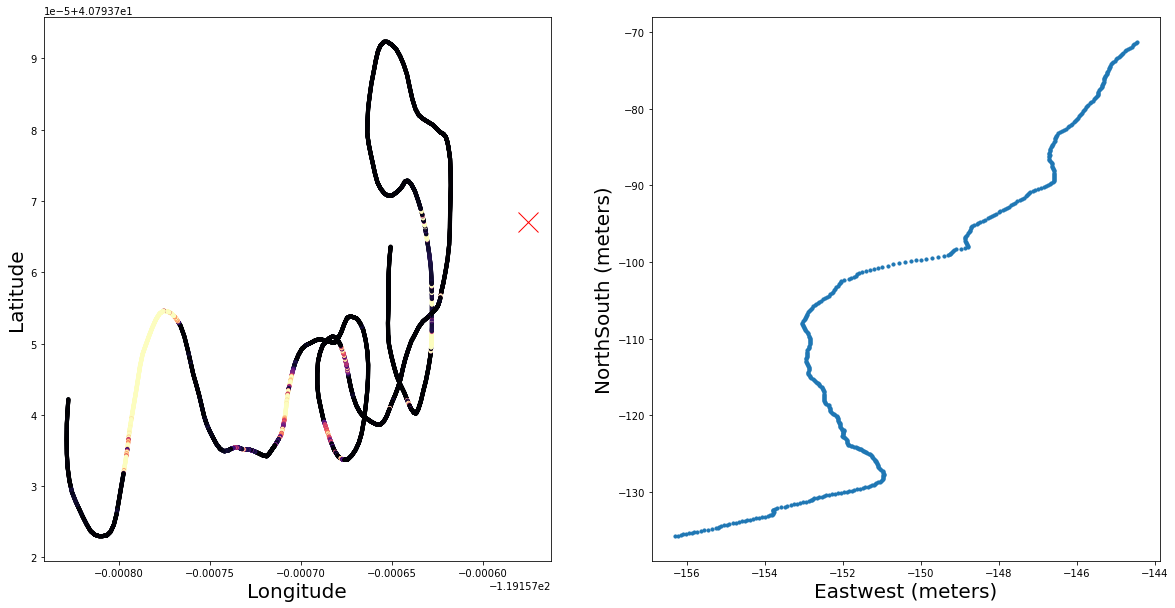

In [121]:
f2, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(dfodor3.lon, dfodor3.lat, c=dfodor3.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(dfwe3.particle0,dfns3.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
#f2.savefig('../figure/position_odor_zoom3.jpg')

### ANIMATION

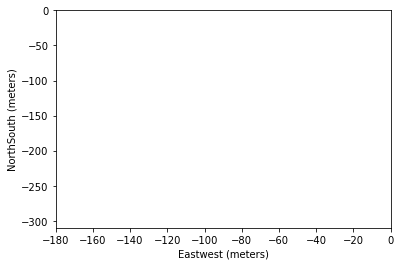

In [85]:
fig = plt.figure()
ax = plt.axes(xlim=(-180,0), ylim=(-310,0))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
line, = ax.plot([],[], 'o', lw=2)

def init():
    line.set_data([],[])
    return line,

def get_data_x(i):
    return delta.loc[i]

def get_data_y(i):
    return gamma.loc[i]

In [86]:
def update(i):
    x = get_data_x(i)
    y = get_data_y(i)
    line.set_data(x,y)
    return line,

In [88]:
ani = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(westeast.index,northsouth.index),
                              interval = 5, blit=False)

ani.save('../figure/basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()


In [196]:
westeast.loc[3]

particle0      -0.607017
particle1      -0.597016
particle2      -0.588016
particle3      -0.591516
particle4      -0.595016
                  ...   
particle2992    0.054001
particle2993    0.066502
particle2994         NaN
particle2995         NaN
particle2996         NaN
Name: 3, Length: 2997, dtype: float64

### PREVIOUS STUFF

In [ ]:
position_U = integrate.cumtrapz(df2.U[1:],df2.time_epoch[1:], axis=0) 
position_V = integrate.cumtrapz(df2.V[1:],df2.time_epoch[1:], axis=0) 
positions = integrate.cumtrapz([df2.U[1:],df2.V[1:]], df2.time_epoch[1:], axis=1) #comprises zboth U & V

In [ ]:
#padding zeros to match length
X = padarray(position_U, 220330)
Y = padarray(position_V, 220330)

In [ ]:
#adding position data to the main df
wind_df['position_u'] = X
wind_df['position_v'] = Y

In [ ]:
plt.scatter(positions[0],positions[1], label='Position')
plt.quiver(positions[0,::3000], positions[1,::3000],
    wind_df.U[1:220329:3000], wind_df.V[1:220329:3000], color='red',
    width=0.01, label='Direction')
plt.legend()

In [ ]:
#TODO: ANIMATION - UPDATE WITH RESPECT TO TIME STAMP or a dt

# %matplotlib notebook
# import seaborn as sns
# plt.style.use('seaborn-pastel')

# fig = plt.figure(figsize=(10,4))
# ax=plt.axes(xlim=(-7000, 1000), ylim=(-1000, 2600))
# line, = ax.plot([], [])

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):   
#     x = wind_df.positions_u
#     y = wind_df.positions_v
#     line.set_data(x, y)
#     return line,

    
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=20, interval=20, blit=True)
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

### Setup Bags - BAG01 - Source Location

In [ ]:
#dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv") 
dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv")

In [ ]:
epoch_setup(dfbag01)

In [ ]:
dfbag01=dfbag01.interpolate()

In [ ]:
# dfbag01.keys()
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag01._ublox_gps_fix_longitude, dfbag01._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.plot(dfbag01.sync_time,dfbag01._ublox_gps_fix_latitude)

In [ ]:
query = 'sync_time > 75 and sync_time < 150'
df_gps= dfbag01.query(query)

In [ ]:
source_location_lat=df_gps._ublox_gps_fix_latitude.mean()
source_location_long=df_gps._ublox_gps_fix_longitude.mean()
source_location=[source_location_lat, source_location_long]
source_location

query = '_analog_output_data > 5 and _analog_output_data <= 10'
df_tmp = dfbag01.query(query)

fig_odor_gps = plt.figure()
ax_odor_gps_filtered = fig_odor_gps.add_subplot(111)
ax_odor_gps_filtered.scatter(df_tmp._ublox_gps_fix_latitude, df_tmp._ublox_gps_fix_longitude, c=df_tmp._ublox_gps_fix_altitude, s=10, cmap='magma')
ax_odor_gps_filtered.set_xlabel('Latitude')
ax_odor_gps_filtered.set_ylabel('Longitude')

plt.plot([40.79376709443614], [-119.15757512132207], marker='x', markersize=20, color="black")

### Setup Bags - BAG02 - Analysis

In [ ]:
dfbag02 = hp.import_csv("~/data/DesertDataOct/Run02/OctoberRun02Bag0.csv") 

In [ ]:
epoch_setup(dfbag02)

### Interpolation Method Comparison

In [ ]:
#compare cubic, spline and linear interpolation
odor_concentration_cubic=dfbag02['_analog_output_data'].interpolate(method='cubic', order=2)
odor_concentration_spline=dfbag02['_analog_output_data'].interpolate(method='spline', order=2)
odor_concentration_linear=dfbag02['_analog_output_data'].interpolate(method='linear')

odor_concentration_spline_clipped = np.clip(odor_concentration_spline, a_min = 0.6, a_max = 10.4) 

In [ ]:
x = dfbag02._analog_output_data
y = dfbag02.time
f = interpolate.interp1d(x,y,kind='cubic')

In [ ]:
df_interpolation = pd.DataFrame()

In [ ]:
df_interpolation.insert(0,'time',dfbag02.sync_time)
df_interpolation.insert(1,'odor_concentration_cubic',odor_concentration_cubic)
df_interpolation.insert(2,'odor_concentration_spline',odor_concentration_spline)
df_interpolation.insert(3,'odor_concentration_linear',odor_concentration_linear)

In [ ]:
df_interpolation

In [ ]:
df_interpolation.insert(4,'odor_concentration',odor_concentration_spline_clipped)

In [ ]:
# fig,((ax_1,ax_2),(ax_3, ax_4))=plt.subplots(2,2,figsize=(15,5))
# fig.tight_layout()

# ax_1.plot(df_interpolation.time, df_interpolation.odor_concentration_cubic)
# ax_1.set_xlabel('Odor_concentration_Cubic')
# ax_1.set_ylabel('Time')
# ax_1.set_xlim(75,300)


# ax_2.plot(df_interpolation.time, df_interpolation.odor_concentration_spline)
# ax_2.set_xlabel('Odor_concentration_Spline')
# ax_2.set_ylabel('Time')
# ax_2.set_xlim(75,300)

# ax_3.plot(df_interpolation.time, df_interpolation.odor_concentration_linear)
# ax_3.set_xlabel('Odor_concentration_Linear')
# ax_3.set_ylabel('Time')
# ax_3.set_xlim(75,300)

# ax_4.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax_4.set_xlabel('Odor_concentration')
# ax_4.set_ylabel('Time')
# ax_4.set_xlim(75,300)

In [ ]:
# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(20,10))
# fig.suptitle('Odor Concentration (v/g) vs Time (seconds)')
# ax1.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax1.set_xlim(102,104) #time
# ax1.set_ylim(0,11) #voltage

# ax2.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax2.set_xlim(151,153)
# ax2.set_ylim(0,11)

# ax3.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax3.set_xlim(175,177)
# ax3.set_ylim(0,11)

# ax4.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax4.set_xlim(227,228)
# ax4.set_ylim(0,11)

# ax5.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax5.set_xlim(255,256)
# ax5.set_ylim(0,11)

# ax6.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax6.set_xlim(299,299.8)
# ax6.set_ylim(0,11) #lower concentration

# fig.text(0.5, 0.04, 'Time', ha='center')
# fig.text(0.08, 0.5, 'Odor Concentration Interpolated', va='center', rotation='vertical')

In [ ]:
# dfbag02_tmp=dfbag02
# dfbag02_tmp.insert(3,'odor_concentration',df_interpolation.odor_concentration)
# dfbag02_tmp.set_index('odor_concentration', inplace=True)
# dfbag02_tmp.interpolate(method='index', inplace=True)
# dfbag02_tmp.reset_index(inplace=True)

In [ ]:
#TODO: interpolate
dfbag02=dfbag02.interpolate(method='linear')

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag02._ublox_gps_fix_longitude, dfbag02._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
dfbag02.time[0]

In [ ]:
dfbag02.time[73437]

In [ ]:
wind_df_bag02 = wind_df.loc[(wind_df.time_epoch >= 1603221192.55) & (wind_df.time_epoch <= 1603221492.29)]
wind_df_bag02.to_hdf('/home/ecc/data/DesertDataOct/StationeryWind/WindStatData_TimeRun02Bag0.h5', key='wind_df_bag02', mode='w')

In [ ]:
query = ' _analog_output_data >= 7'
dfbag02_tmp = dfbag02.query(query)

In [ ]:
fig_odor_gps = plt.figure()
ax= fig_odor_gps.add_subplot(111)
cmap = plt.cm.get_cmap("magma", 10)
#ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
#ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')


In [ ]:
#zoom gps
# fig_gps = plt.figure()
# ax= fig_gps.add_subplot(111)
# cmap = plt.cm.get_cmap("magma", 10)
# #ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
# ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
# #ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Longitude')

# #TODO: get the correct limits
# ax.set_xlim(40.79300074,40.79300076)

In [ ]:
wind_df_bag02.keys()

In [ ]:
plt.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v, label='Position')
plt.quiver(wind_df_bag02.position_u[::300], wind_df_bag02.position_v[::300],
    wind_df_bag02.U[::300], wind_df_bag02.V[::300], color='red',
    width=0.01, label='Direction')
plt.legend()

In [ ]:
fig_odor_gps = plt.figure()
ax= fig_odor_gps.add_subplot(111)
cmap = plt.cm.get_cmap("magma", 10)
#ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
#ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
#ax.plot(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')


In [ ]:
#### Need to scale these two trajectories

In [ ]:
# plt.plot(wind_df.position_u, wind_df.position_v)
# plt.xlim(-3125, -2900)
# plt.ylim(200,600)

In [ ]:
#TEST
# A = [1,2,3,4,5,6,7]
# T = [1,2,3,4,5,6,7]
# B = []
# C = []
# D= []
# C = integrate.cumtrapz(A,T)
# for i in range(len(A)-1):
#     B.append(np.trapz([A[i],A[i+1]],[T[i], T[i+1]]))
# print(B)
# print(C)

#TEST2
# arr1 =[]
# arr2 =[]
# for i in range(len(y)):
#     if i==0:
#         arr1.append(0)
#     else:
#         arr1.append(y[i]+arr1[i-1])

# for i in range(len(z)):
#     if i==0:
#         arr2.append(0)
#     else:
#         arr2.append(z[i]+arr2[i-1])

# #arr1 = U zonal velocity ; eastwest
# #arr2 = V meridian velocity; Northsouth
# particle = list(zip(u,v))
# particle
# plt.plot(particle)

#TEST3
#without for loop integration using cumsum ; dt selected from averaging the difference of the time stamps
# a=np.cumsum(wind_df[1:].U*dt)
# b=np.cumsum(wind_df[1:].V*dt)

# fig, (ax_eastwest, ax_northsouth) = plt.subplots(1,2,figsize=(15,5))

# ax_eastwest.plot(a)
# ax_northsouth.plot(b)

### Intergration for every time stamp (not cumulative addition)

In [ ]:
# #integration of U vector
# u=[]
# for i in range(len(wind_df.U)-1):
#     u.append(np.trapz([wind_df.U[i],wind_df.U[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
# #integration of V vector
# v=[]
# for i in range(len(wind_df.V)-1):
#     v.append(np.trapz([wind_df.V[i],wind_df.V[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
    
# fig,(ax_u,ax_v)=plt.subplots(1,2,figsize=(15,5))
# ax_u.plot(wind_df.sync_time[:220329], u)
# ax_v.plot(wind_df.sync_time[:220329], v)